# Sentiment analysis.

In this notebook we are going to use the **Amazon Review Dataset** to test Promptmeteo in the sentiment analysis task

## Data Preparation - Build sentiment dataset.

The dataset contains reviews from Amazon in English collected between November 1, 2015 and November 1, 2019. Each record in the dataset contains the review text, the review title, the star rating, an anonymized reviewer ID, an anonymized product ID and the coarse-grained product category (e.g. ‘books’, ‘appliances’, etc.). The corpus is balanced across stars, so each star rating constitutes 20% of the reviews in each language.

In [1]:
import polars as pl

data = pl.read_parquet('../data/amazon_reviews_en/amazon_reviews_multi-test.parquet')
data.head()

review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
str,str,str,i32,str,str,str,str
"""en_0199937""","""product_en_090…","""reviewer_en_00…",1,"""These are AWFU…","""Don’t waste yo…","""en""","""apparel"""
"""en_0863335""","""product_en_034…","""reviewer_en_06…",1,"""I bought 4 and…","""One Star""","""en""","""other"""
"""en_0565010""","""product_en_035…","""reviewer_en_09…",1,"""On first use i…","""Totally useles…","""en""","""other"""
"""en_0963290""","""product_en_058…","""reviewer_en_02…",1,"""You want an HO…","""Gold filled ea…","""en""","""jewelry"""
"""en_0238156""","""product_en_048…","""reviewer_en_05…",1,"""The glue works…","""Poor container…","""en""","""industrial_sup…"


For building a sentiment analysis dataset with the dataset we create the **target** using the variable `stars`. We supone that the reviews with low stars rate are related with negative sentiment and those with high starts rate are related with positive sentiment.

In [2]:
sql = pl.SQLContext()
sql.register('data', data)

sentiment_data = sql.execute("""
    SELECT
        review_body as REVIEW,
        CASE
            WHEN stars=1 THEN 'negative'
            WHEN stars=3 THEN 'neutral'
            WHEN stars=5 THEN 'positive'
            ELSE null
        END AS TARGET,
    FROM data
    WHERE stars!=2 AND stars!=4;
    """).collect().sample(fraction=1.0, shuffle=True, seed=0)

sentiment_data.head()

REVIEW,TARGET
str,str
"""I reuse my Nes…","""positive"""
"""Fits great kin…","""positive"""
"""Movie freezes …","""negative"""
"""This is my thi…","""positive"""
"""For the money,…","""neutral"""


## Classification with Promptmeteo

### Build prompt for the task

Promptmeteo has a concreate prompt formatting following a YAML structure. This structure allows Promptmeteo to validate, and use different promtpting techniques according to the prompt and the task.

In [3]:
sentiment_prompt = '''
TEMPLATE:
    "
    Your task is to classify a text in categories:
    {__LABELS__}

    {__TASK_INFO__}

    {__ANSWER_FORMAT__}

    {__CHAIN_OF_THOUGHTS__}
    "

LABELS:
    ["positive", "negative", "neutral"]

TASK_INFO:
    "The text is a sentence written by a human and you have to classify
    it in according to its sentiment."

ANSWER_FORMAT:
    "Your answer must include the name of the category in a unique word
    in lower case and without puntuation."

CHAIN_OF_THOUGHTS:
    "Please explain your answer step by step before saying the name of
    the category"
'''

In [4]:
import sys; sys.path.append('..')
from promptmeteo import Promptmeteo

model = Promptmeteo(
    task_type            = 'classification',
    model_name           = 'text-davinci-003',
    model_provider_name  = 'openai',
    model_provider_token = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'  #OPENAI TOKEN
).read_prompt_file(sentiment_prompt)

### Train the model

The training process create a vector database in memory with **FAISS**, the main advantage of using this king of vector database is that it is serializable to a file and be stored in disk, which allows us to save the vectors training process as a model artifact

In [5]:
train_reviews = sentiment_data.head(100).select('REVIEW').to_series().to_list()
train_targets = sentiment_data.head(100).select('TARGET').to_series().to_list()

model = model.train(
    examples = train_reviews,
    annotations = train_targets
)

### Predict new data

<Axes: >

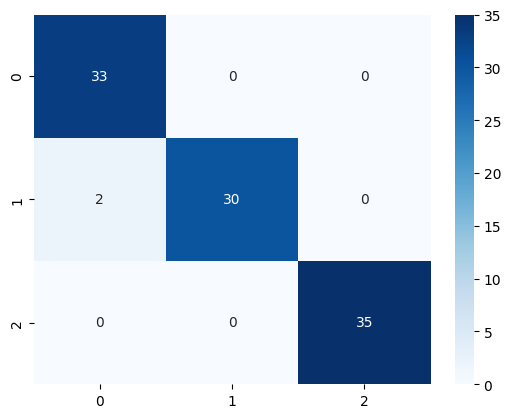

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_reviews = sentiment_data.head(100).select('REVIEW').to_series().to_list()
test_targets = sentiment_data.head(100).select('TARGET').to_series().to_list()

pred_targets = model.predict(test_reviews)

sns.heatmap(confusion_matrix(test_targets, pred_targets), annot=True, cmap='Blues')